In [1]:
from matplotlib import pyplot as plt
from skimage import data

In [194]:
class seam_carver:
    def __init__(self, image):
        #note: image is a just a 2d array of RGB tuples
        self.image = image
        self.width = len(image[0])
        self.height = len(image)
        self.energy_grid = []
        
    def energy(self, row, col):
        '''calculates energy. energy is defined as $\delta_x^2(x, y) + \delta_y^2(x, y)$
        where $\delta_y(x, y)$ is defined $R_y(x, y) + G_y(x, y) + B_y(x, y)$, where 
        $R_x(x, y) = | (x, y - 1)_{RED} - (x, y + 1)_{RED} |$ and similarly for G, B
        I.e, the energy is high for a pixel between two pixels of vastly different colors
        For edge (haha) cases, just think of the image as a torus (or experiment with other options)'''
        def color_gradient(row, col, direction, color):
            color_to_index = {"R": 0, "G":1, "B":2}
            delta_r, delta_c = 0, 0
            if direction == "H":
                delta_c = 1
            elif direction == "V":
                delta_r = 1
            return abs(self.image[(row - delta_r)%self.height][(col - delta_c)%self.width][color_to_index[color]]
                       - self.image[(row + delta_r)%self.height][(col + delta_c)%self.width][color_to_index[color]])
        energy = 0
        for d in "HV":
            dir_en = 0
            for c in "RGB":
                dir_en += color_gradient(row, col, d, c)**2
            energy += dir_en
        return energy
        
    def create_energy_grid(self):
        #TODO: iterate through image, calculating energy for each pixel
        #store the results in self.energy_grid
        self.energy_grid = [[None for i in range(self.width)] for j in range(self.height)]
        for row in range(self.height):
            for col in range(self.width):
                self.energy_grid[row][col] = self.energy(row, col)
        
    def shortest_path(self, orientation = "V"):
        #TODO: assert that the image is the same size as the energy grid
        shortest_paths = {}

        def path_val(path):
            return sum([self.energy_grid[row][col] for row, col in path])

        def helper(row, col):
            #if we've already solved this subproblem, just remember it
            if((row, col) in shortest_paths):
                return shortest_paths[(row, col)]
            #if we are at the bottom row, than we are done
            if(row == self.height - 1 and orientation == "V") or (col == self.width - 1 and orientation == "H"):
                shortest_paths[(row, col)] = [(row, col)]
                return [(row, col)]
            shortest_path = None
            #Note: this is the euclidean way to think of this
            adj = []
            if orientation == "V":
                adj = [(1, -1), (1, 0), (1, 1)]
            else:
                adj = [(-1, 1), (0, 1), (1, 1)]
            for delta_r, delta_c in adj:
                #if we're going to go off the side, don't
                #note that we don't need to worry about going off the bottom because of the base case
                if((col + delta_c >= self.width or col + delta_c < 0) and orientation == "V") or ((row + delta_r >= self.height or row + delta_r < 0) and orientation == "H"):
                    continue
                cur_path = [(row, col)] + helper(row + delta_r, col + delta_c)
                #if there is no shortest path, or this is shorter, take this route
                if shortest_path is None:
                    shortest_path = cur_path
                elif path_val(shortest_path) > path_val(cur_path):
                    shortest_path = cur_path
            #remember the result and return it
            shortest_paths[(row, col)] = shortest_path
            return shortest_path
        #to find the shortest from top to bottom, we just have to look at each possible starting point
        #percolation!
        if orientation == "V":
            return min([helper(0, c) for c in range(self.width)], key = lambda path : path_val(path))
        else:
            return min([helper(r, 0) for r in range(self.height)], key = lambda path : path_val(path))
    
    def removeVerticalSeam(self):
        self.create_energy_grid()
        to_remove = self.shortest_path()
        for row, col in to_remove:
            self.image[row].pop(col)
        self.width -= 1
        
    def removeHorizontalSeam(self):
        #This is just begging to be refactored. Although the complexity of finding the path is much
        #worse than the complexity of transposing the matrix, this is still kind of clunky.
        self.image = self.transpose(self.image)
        self.height, self.width = self.width, self.height
        self.removeVerticalSeam()
        self.image = self.transpose(self.image)
        self.height, self.width = self.width, self.height
        
    def transpose(self, arr):
        T = [[None for i in range(len(arr))] for j in range(len(arr[0]))]
        for x in range(len(arr)):
            for y in range(len(arr[0])):
                T[y][x] = arr[x][y]
        return T

Create a new seam carver with a nice image to experiment on

In [195]:
coffee = seam_carver(data.coffee().tolist())

Remove a couple pixels from each column

In [201]:
for i in range(10):
    coffee.removeHorizontalSeam()

The original image

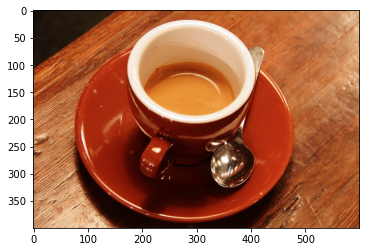

In [202]:
plt.imshow(data.coffee())

The shorter image

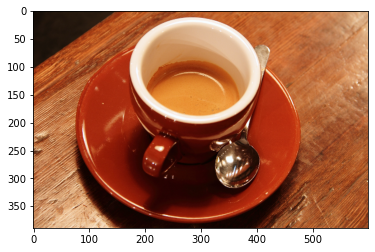

In [203]:
plt.imshow(coffee.image)

Now has height of 

In [204]:
coffee.height

389

Now remove a couple pixels from each row

In [205]:
for i in range(10):
    coffee.removeVerticalSeam()

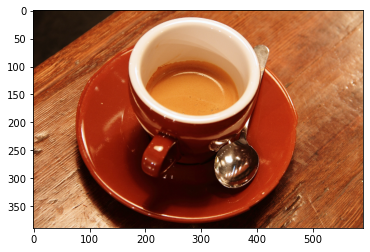

In [206]:
plt.imshow(coffee.image)

In [207]:
coffee.height, coffee.width

(389, 590)

Another example

In [9]:
rocket_seam = seam_carver(data.rocket().tolist())

In [ ]:
for i in range(50):
    rocket_seam.removeVerticalSeam()

In [ ]:
plt.imshow(data.rocket())

In [ ]:
plt.imshow(rocket_seam.image)